# Callbacks

> State's callbacks and variables

In [ ]:
#| default_exp callbacks

In [ ]:
#|export
from dataclasses import dataclass

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="The weights matrix is not fully connected")

In [ ]:
#|export
from pysal.lib import weights
from pysal.explore import esda
import itertools
import fastcore.all as fc
from fastcore.basics import patch
import numpy as np
from scipy.spatial import KDTree
import geopandas as gpd
from typing import List
from collections.abc import Callable
import rasterio
from rasterio.mask import mask
import pandas as pd

In [ ]:
#| hide
from trufl.utils import gridder
from trufl.sampler import Sampler
import pandas as pd

red, black = '#BF360C', '#263238'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#|export
@dataclass
class Variable:
    "State variable"
    name: str
    value: float

In [ ]:
#|export
class Callback(): pass

## State

In [ ]:
#|export
class State:
    def __init__(self, 
                 measurements:gpd.GeoDataFrame, # Measurements data with `loc_id`, `geometry` and `value` columns. 
                 cbs:List[Callable] # List of Callback functions returning `Variable`s.
                ): 
        "Collect various variables/metrics per grid cell/administrative unit."
        fc.store_attr()

In [ ]:
#| export
@patch
def get(self:State, 
        loc_id:str, # Unique id of the Point feature
        as_numpy=False # Whether or not to return a list of `Variable` or a tuple of numpy arrays.
       ):
    "Get the state variables as defined by `cbs` for a given location (`loc_id`)."
    variables = self.run_cbs(loc_id)
    if as_numpy:
        return (np.array([v.name for v in variables]), 
                np.array([v.value for v in variables]))
    else:
        return variables

In [ ]:
#| export
@patch
def __call__(self:State, loc_id=None, **kwargs):
    "Get the state variables as defined by `cbs` for all `loc_id`s as a dataframe."
    if loc_id is not None: return self.get(loc_id, kwargs)
    results = [
        {v.name: v.value for v in self.run_cbs(loc_id)} | {'loc_id': loc_id}
        for loc_id in self.measurements.loc_id.unique()
    ]
    return pd.DataFrame(results).set_index('loc_id')

In [ ]:
#| export
@patch
def expand_to_k_nearest(self:State, 
                        subset_measurements:gpd.GeoDataFrame, # Measurements for which Variables are computed.
                        k:int=5, # Number of nearest neighbours (possibly belonging to adjacent cells/admin. units to consider).
                       ):
    "Expand measurements of concern possibly to nearest neighbors of surrounding grid cells."
    tree = KDTree(self.measurements.geometry.apply(lambda p: (p.x, p.y)).tolist());
    _, indices = tree.query(subset_measurements.geometry.apply(lambda p: (p.x, p.y)).tolist(), k=k)
    return self.measurements.iloc[indices.flatten()].reset_index(drop=True)

In [ ]:
#| export
@patch
def _flatten(self:State, variables):
    "Flatten list of variables potentially containing both scalar and tuples."
    return list(itertools.chain(*(v if isinstance(v, tuple) else (v,) 
                                  for v in variables)))

In [ ]:
#| export
@patch
def run_cbs(self:State, loc_id):
    "Run Callbacks sequentially and flatten the results if required."
    variables = []
    for cb in self.cbs:
        variables.append(cb(loc_id, self))
    return self._flatten(variables)

## Callbacks

In [ ]:
#|export
class MaxCB(Callback):
    "Compute Maximum value of measurements at given location."
    def __init__(self, name='Max'): fc.store_attr()
    def __call__(self, loc_id, state): 
        return Variable(
            self.name, 
            np.max(state.measurements[state.measurements.loc_id == loc_id]['value'].values))

In [ ]:
#|export
class MinCB(Callback):
    "Compute Minimum value of measurements at given location."
    def __init__(self, name='Min'): fc.store_attr()
    def __call__(self, loc_id, state): 
        return Variable(
            self.name, 
            np.min(state.measurements[state.measurements.loc_id == loc_id]['value'].values))

In [ ]:
#|export
class StdCB(Callback):
    "Compute Standard deviation of measurements at given location."
    def __init__(self, name='Standard Deviation'): fc.store_attr()
    def __call__(self, loc_id, state): 
        return Variable(
            self.name, 
            np.std(state.measurements[state.measurements.loc_id == loc_id]['value'].values))

In [ ]:
#|export
class CountCB(Callback):
    "Compute the number of measurements at given location."
    def __init__(self, name='Standard Deviation'): fc.store_attr()
    def __call__(self, loc_id, state): 
        return Variable(
            'Count', 
            len(state.measurements[state.measurements.loc_id == loc_id]['value'].values))

In [ ]:
#|export
class MoranICB(Callback):
    "Compute Moran.I of measurements at given location. Return NaN if p_sim above threshold."
    def __init__(self, k=5, p_threshold=0.05, name='Moran.I', min_n=5): fc.store_attr()

    def _weights(self, measurements):
        w = weights.KNN.from_dataframe(measurements, k=self.k)
        w.transform = "R" # Row-standardization
        return w
        
    def __call__(self, loc_id, state): 
        subset = state.measurements[state.measurements.loc_id == loc_id]
        if len(subset) <= self.min_n: return Variable(self.name, np.nan)
        expanded_measurements = state.expand_to_k_nearest(subset, k=self.k)
        moran = esda.moran.Moran(expanded_measurements['value'], self._weights(expanded_measurements))
        return Variable(self.name, moran.I if moran.p_sim < self.p_threshold else np.nan)

For example:

We generate a grid from a given raster file:

In [ ]:
#|eval: false
fname_raster = 'files/ground-truth-01-4326-simulated.tif'
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)

Then, we can emulate a data collection campaign:

In [ ]:
#|eval: false
sampler = Sampler(fname_raster)

# Random planned measurements to be carried out to demo tha workflow
n_planned = np.random.randint(1, high=10, size=len(gdf_grid), dtype=int)
loc_ids = gdf_grid.loc_id.values

samples_t0 = []
for loc_id, n in zip(loc_ids, n_planned):    
    sampling_locs = gdf_grid.loc[gdf_grid.loc_id == loc_id].sample_points(n)
    gdf_samples = sampler.sample(sampling_locs)
    samples_t0.append(gdf_samples)

gdf_samples_t0 = pd.concat(samples_t0)
gdf_samples_t0.head()

,loc_id,geometry,value
0,0,POINT (-1.21707 43.26500),0.130260
1,0,POINT (-1.21167 43.26497),0.070750
2,0,POINT (-1.21018 43.26403),0.059421
3,0,POINT (-1.20968 43.26171),0.077387
0,1,POINT (-1.22324 43.27666),0.000000


In [ ]:
#|eval: false
state = State(gdf_samples_t0, [MaxCB(), MinCB(), StdCB(), CountCB(), MoranICB(k=5)])

To get the state for all grid cells at once as a `pd.DataFrame`:

In [ ]:
#|eval: false
state()

,Max,Min,Standard Deviation,Count,Moran.I
loc_id,,,,,
0,0.143291,0.067056,0.024741,9,0.494134
1,0.150723,0.114307,0.012697,7,0.598283
2,0.173205,0.163468,0.003725,4,NaN
3,0.204352,0.186849,0.007078,4,NaN
4,0.225564,0.177689,0.015292,7,0.195251
...,...,...,...,...,...
95,0.889606,0.855016,0.012415,4,NaN
96,0.829922,0.750345,0.025490,7,0.410367
97,0.740519,0.681251,0.029634,2,NaN


Or, to get the state of a specific `loc_id`, either:

In [ ]:
#|eval: false
state.get(loc_id=0, as_numpy=True)

(array(['Max', 'Min', 'Standard Deviation', 'Count', 'Moran.I'],
       dtype='<U18'),
 array([0.14329131, 0.06705605, 0.02474131, 9.        , 0.4941342 ]))

Or more succintly:

In [ ]:
#|eval: false
state(loc_id=0, as_numpy=False)

(array(['Max', 'Min', 'Standard Deviation', 'Count', 'Moran.I'],
       dtype='<U18'),
 array([0.14329131, 0.06705605, 0.02474131, 9.        , 0.4941342 ]))

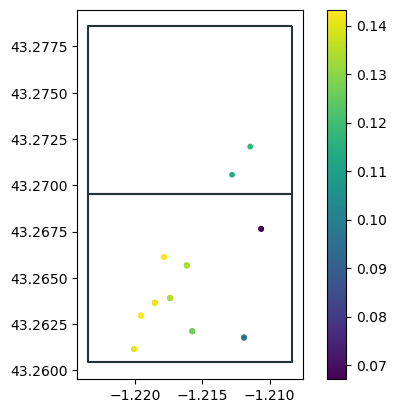

In [ ]:
#|eval: false
subset = state.measurements[state.measurements.loc_id == 0]; subset.head()

expanded_gpd = state.expand_to_k_nearest(subset, k=5)
ax = expanded_gpd.plot(column='value', s=10, legend=True)
gdf_grid[gdf_grid.loc_id.isin(expanded_gpd.loc_id.unique())].boundary.plot(color=black, ax=ax);

In [ ]:
#|export
class PriorCB(Callback):
    "Emulate a prior by taking the mean of measurement over a single grid cell."
    def __init__(self, 
                 grid:gpd.GeoDataFrame, # Grid of polygons of interest
                 fname_raster:str, # Name of raster file
                ): 
        fc.store_attr()

    def __call__(self, loc_id, state): 
        polygon = self.grid.loc[self.grid.loc_id == loc_id].geometry
        with rasterio.open(self.fname_raster) as src:
            out_image, out_transform = mask(src, polygon, crop=True)
            mean_value = np.mean(out_image)
        return Variable('Prior', mean_value)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()